# 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧
# ⚠ Work in progress ⚠
# 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
from olistdash.utils import *
import numpy as np
import statsmodels.formula.api as smf

In [2]:
# Import data
from olistdash.data import Olist
from olistdash.order import Order

In [3]:
data = Olist().get_data()
orders = Order().get_training_data()
matching_table = Olist().get_matching_table()

# Restricting customer states

Investigating the impact of preventing customers ordering products to certain states.

Steps:

- Looking the share of one-star orders by state.
- measuring the cumulative share of one-star reviews and orders by state in descending order: this allows us to understand which state contributes the most to the overall share of one-star reviews.
- making an informed decision by outputing `review_score` impact and `orders` loss.

### Merging orders with customer states

First step: Retrieving orders with customer state

In [4]:
# Merge to get order and customer_state in a DataFrame
mask_columns = ['order_id', 'customer_id']
order_customer = matching_table.drop_duplicates(subset=mask_columns)[mask_columns]
order_state = order_customer.merge(data['customers'], 
                                   on='customer_id')[['order_id', 'customer_state']]
orders = orders.merge(order_state, 
                      on='order_id')

### Compute cost and revenue at the order level

In [5]:
cost_mapping = {1:100, 2:50, 3:40, 4:0, 5:0}

In [6]:
orders['cost'] = orders['review_score'].map(cost_mapping)
orders['revenue'] = orders['price'] * 0.1

### Share of one-star reviews per state

Measuring the share of one star orders per customer state.

In [7]:
orders.groupby('customer_state')\
      .agg({'dim_is_one_star':'mean',
            'order_id':'count'})\
      .sort_values(by='dim_is_one_star', 
                   ascending=False).head()

,dim_is_one_star,order_id
customer_state,,
MA,0.162275,721
AL,0.159601,401
SE,0.155224,335
RJ,0.151771,12420
PA,0.149003,953


?? Rio de Janeiro state has 15% of orders as one-star reviews.

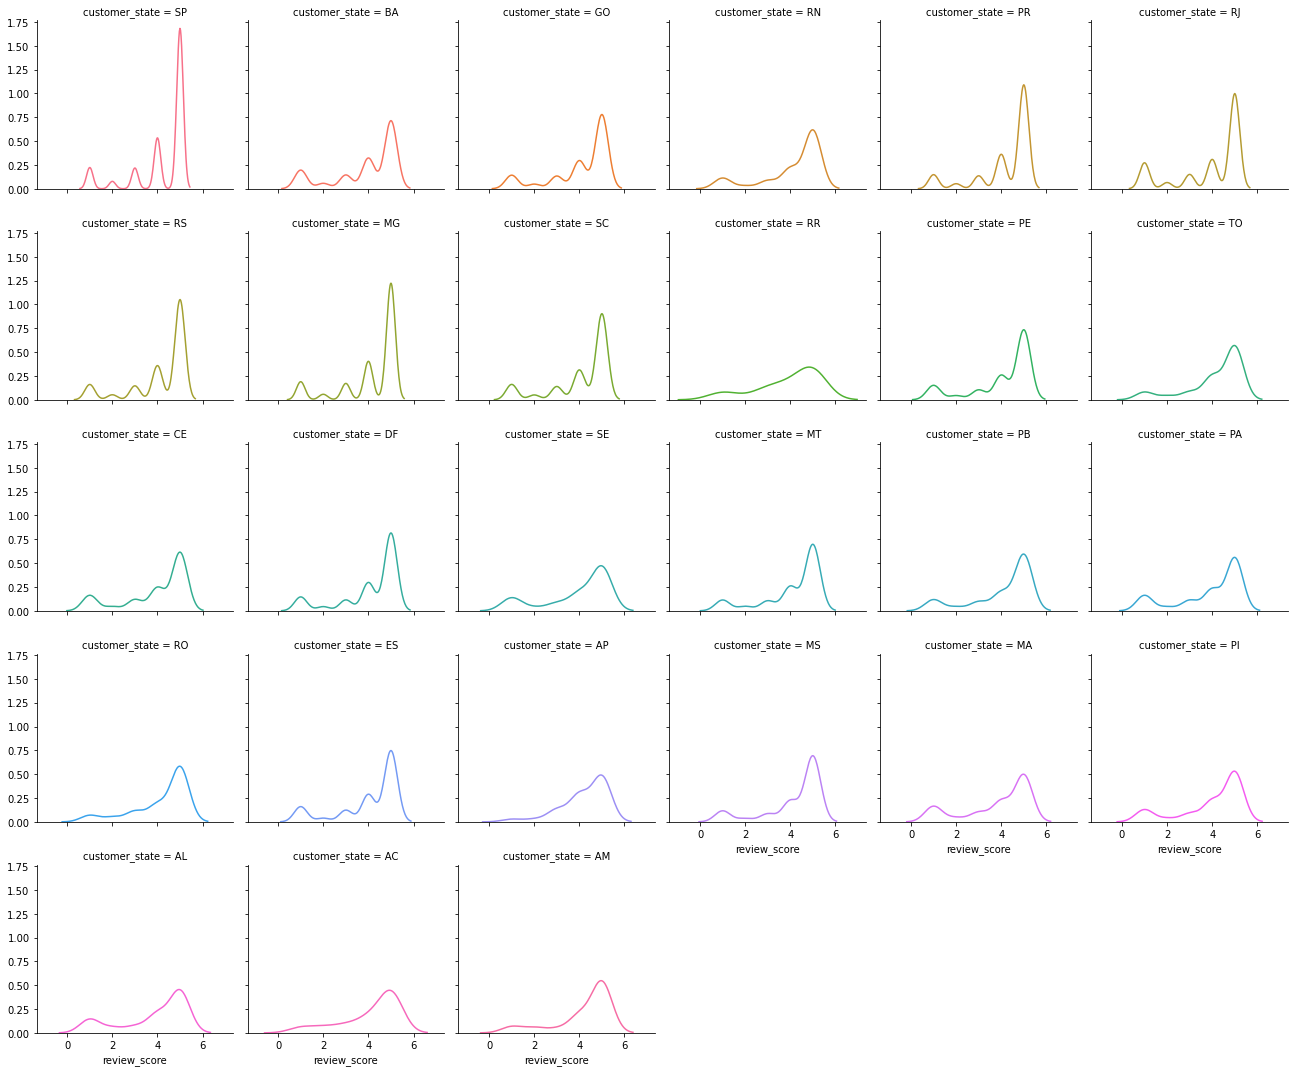

In [10]:
g = sns.FacetGrid(orders, col="customer_state", col_wrap=6, hue='customer_state')
g.map(sns.kdeplot, "review_score")

### Cumulative share of cost, revenue and orders

Computing the cumulative share of cost in order to measure the contribution of each state.

In [11]:
orders_agg = orders.groupby('customer_state')\
                   .agg({'cost':'sum',
                         'revenue':'sum',
                         'order_id':'count'})\
                   .sort_values(by='cost', 
                                ascending=False)

Computing the metric `ratio` as the ratio of the `cost` to the `revenue`. A higher value means that a state contributes more to the `cost` than to the `revenue`:

In [14]:
orders_agg['share_total_cost'] =\
    orders_agg['cost'] / orders_agg['cost'].sum()

orders_agg['share_total_revenue'] =\
    orders_agg['revenue'] / orders_agg['revenue'].sum()

orders_agg['ratio'] =\
    orders_agg['share_total_cost'] / orders_agg['share_total_revenue'] 

Sorting by this ratio and computing a **cumulative sum** on both orders and one-star orders:

In [15]:
orders_agg.sort_values(by='ratio', 
                       ascending=False, 
                       inplace=True)

In [17]:
orders_agg['cum_share_cost'] = orders_agg['cost'].cumsum() / orders_agg['cost'].sum()

orders_agg['cum_share_revenue'] = orders_agg['revenue'].cumsum() / orders_agg['revenue'].sum()

orders_agg['rank'] = orders_agg['cum_share_cost'].rank()

In [18]:
orders_agg.head()

,cost,revenue,order_id,share_total_cost,share_total_revenue,ratio,cum_share_cost,cum_share_revenue,rank
customer_state,,,,,,,,,
RJ,252600,176625.697,12420,0.174413,0.133003,1.311345,0.174413,0.133003,1.0
MA,16000,11720.526,721,0.011048,0.008826,1.251729,0.185460,0.141829,2.0
BA,64350,49583.673,3274,0.044432,0.037338,1.190001,0.229892,0.179166,3.0
ES,33690,26923.052,2004,0.023262,0.020274,1.147399,0.253154,0.199440,4.0
SE,6960,5657.419,335,0.004806,0.004260,1.128050,0.257959,0.203700,5.0


Plotting those two curves on a graph:

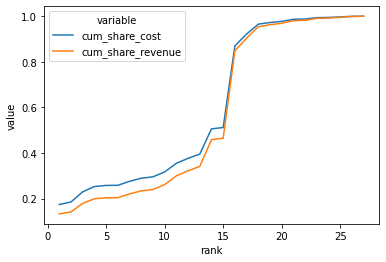

In [20]:
orders_agg_melt = orders_agg[['rank', 
                          'cum_share_cost', 
                          'cum_share_revenue']].melt(id_vars=['rank'], 
                                                    value_vars=['cum_share_cost', 
                                                                'cum_share_revenue'])
ax = sns.lineplot(x="rank", 
                  y="value", 
                  hue="variable", 
                  data=orders_agg_melt)

?? The plot and the table above let us see that Rio de Janerio alone contributes 17% of the cost and 13% of the revenue.

### Simulation table

Simulating the impact of removing top states on the overall review_score and share_one star: 

In [21]:
def recompute_metrics(rank):
    list_states = orders_agg[orders_agg['rank'] <= rank].index.to_list()
    df = orders.query("customer_state!="+str(list_states))
    review_score = df['review_score'].mean()
    n_orders = df.shape[0]
    orders_impact =  n_orders - orders.shape[0]
    share_one_star = df['dim_is_one_star'].sum() / n_orders
    margin_ratio = df['revenue'].sum() / df['cost'].sum()
    return {'rank':rank,
            'states_removed':str(list_states),
            'review_score':review_score,
            'share_one_star':share_one_star,
            'orders_impact':orders_impact,
            'margin_ratio':margin_ratio}

In [22]:
a = {}
for i in np.arange(0,7):
    a[i] = recompute_metrics(i)

In [23]:
pd.DataFrame(a).T

,rank,states_removed,review_score,share_one_star,orders_impact,margin_ratio
0,0,[],4.142237,0.100539,0,0.916933
1,1,['RJ'],4.171173,0.093017,-12420,0.962925
2,2,"['RJ', 'MA']",4.174195,0.092421,-13141,0.966049
3,3,"['RJ', 'MA', 'BA']",4.184944,0.090629,-16415,0.97733
4,4,"['RJ', 'MA', 'BA', 'ES']",4.188362,0.089937,-18419,0.98288
5,5,"['RJ', 'MA', 'BA', 'ES', 'SE']",4.189603,0.089658,-18754,0.983981
6,6,"['RJ', 'MA', 'BA', 'ES', 'SE', 'RR']",4.189753,0.089641,-18795,0.984084


_Note_: if Olist were to stop selling in `RJ`, this would: 
- Increase review score to 4.17
- Bring share of one star reviews below 10% 
- Reach a 1.92 margin ratio 
- Come at the cost of 12k orders 

---
# 🚧
# Work in progress ⚠
# 🚧
---